# Comparison of Dina startup to TokaMaker (recreate EQ w/o eddy currents and compute stability)

In [1]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import CubicSpline
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh
from OpenFUSIONToolkit.TokaMaker.util import create_isoflux, read_eqdsk

In [3]:
def read_coil_currs(filename):
    with open(filename,'r') as fid:
        fid.readline()
        fid.readline()
        fid.readline()
        vals = np.array([float(val) for val in fid.readline().split()])
    return vals

# Inputs

In [4]:
time_pt = 4000
eqdsk = read_eqdsk('1MA_eqdsk_currs/{0:d}msec/nsf_ntt.{0:06d}'.format(time_pt))
coil_currs = read_coil_currs('1MA_eqdsk_currs/{0:d}msec/fc.txt'.format(time_pt))

In [5]:
mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('../nextstep_mesh_0801.h5')

In [6]:
mygs = TokaMaker()
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
mygs.setup(order=2, F0=eqdsk['rcentr']*eqdsk['bcentr']) ## F0 = B0 * R0

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   tMaker_eddy_modes
Revision id:          c435b10
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  6.143E+00
    # of points  =   10020
    # of edges   =   29927
    # of cells   =   19908
    # of boundary points =     130
    # of boundary edges  =     130
    # of boundary cells  =     130
  Resolution statistics:
    hmin =  3.000E-03
    hrms =  2.845E-02
  

In [7]:
coil_regmat = np.eye(mygs.ncoils+1, dtype=np.float64)
coil_reg_weights = 1.E4*np.ones((mygs.ncoils+1,), dtype=np.float64)
coil_reg_targets = np.zeros((mygs.ncoils+1,), dtype=np.float64)

imap = [0,1,2,3,10,4,9,5,8,6,7,-1,-1,12,11]
for key, coil_set in mygs.coil_sets.items():
    i = coil_set['id']
    if i >= len(imap):
        break
    if imap[i] < 0:
        continue
    coil_reg_targets[i] = coil_currs[imap[i]]*1000.0
    coil_reg_weights[i] = 1.E-1

# Terms for virtual VSC coil (unused)
coil_reg_weights[-1] = 1.E4

mygs.set_coil_reg(coil_regmat,reg_weights=coil_reg_weights,reg_targets=coil_reg_targets)

In [8]:
ffprim = eqdsk['ffprim']
pprime = eqdsk['pprime']


psi_eqdsk = np.linspace(0.0,1.0,np.size(ffprim))
psi_sample = np.linspace(0.0,1.0,np.size(ffprim))

psi_prof = np.copy(psi_sample)
ffp_prof = np.transpose(np.vstack((psi_prof,np.interp(psi_sample,psi_eqdsk,ffprim)))).copy()
pp_prof = np.transpose(np.vstack((psi_prof,np.interp(psi_sample,psi_eqdsk,pprime)))).copy()

mygs.set_profiles(ffp_prof={'type': 'linterp', 'y': ffp_prof[:,1], 'x': psi_sample},pp_prof={'type': 'linterp', 'y': pp_prof[:,1], 'x': psi_sample})

In [9]:
mygs.set_targets(Ip = eqdsk['ip'], pax=eqdsk['pres'][0])

In [10]:
isoflux_pts = eqdsk['rzout'].copy()
mygs.set_isoflux(isoflux_pts)

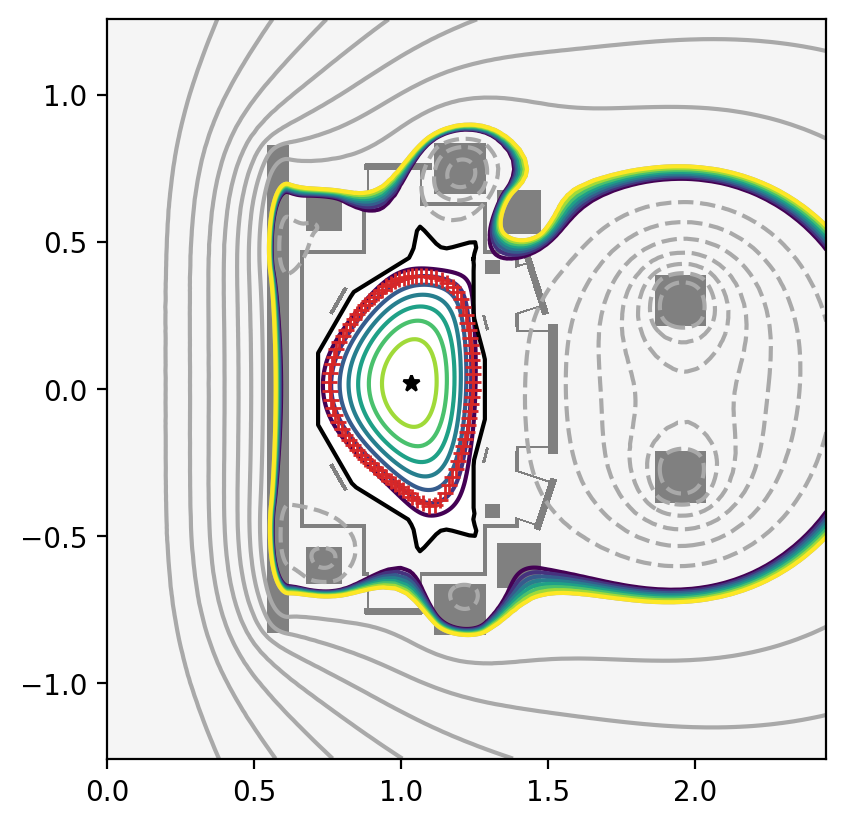

In [11]:
mygs.init_psi(1,0,0.25, 1.7,-0.5)
fig, ax = plt.subplots()
mygs.plot_psi(fig,ax)
mygs.plot_machine(fig,ax)
mygs.plot_constraints(fig,ax)

In [12]:
mygs.solve()
mygs.print_info()

Starting non-linear GS solver
     1  1.2276E+00  3.1985E-06  4.6455E-03  1.0282E+00  2.1247E-02 -0.0000E+00
     2  1.4969E+00  1.6189E-06  2.7340E-03  1.0260E+00  2.1840E-02 -0.0000E+00
     3  1.6963E+00  1.4531E-06  1.6380E-03  1.0247E+00  2.2187E-02 -0.0000E+00
     4  1.8158E+00  1.3696E-06  9.2964E-04  1.0238E+00  2.2573E-02 -0.0000E+00
     5  1.8821E+00  1.3240E-06  5.1993E-04  1.0233E+00  2.2895E-02 -0.0000E+00
     6  1.9185E+00  1.3002E-06  2.9234E-04  1.0229E+00  2.3159E-02 -0.0000E+00
     7  1.9387E+00  1.2878E-06  1.6726E-04  1.0227E+00  2.3373E-02 -0.0000E+00
     8  1.9501E+00  1.2812E-06  9.7981E-05  1.0226E+00  2.3544E-02 -0.0000E+00
     9  1.9566E+00  1.2777E-06  5.9091E-05  1.0225E+00  2.3678E-02 -0.0000E+00
    10  1.9604E+00  1.2757E-06  3.6847E-05  1.0224E+00  2.3782E-02 -0.0000E+00
    11  1.9626E+00  1.2746E-06  2.3785E-05  1.0224E+00  2.3863E-02 -0.0000E+00
    12  1.9640E+00  1.2740E-06  1.5871E-05  1.0224E+00  2.3925E-02 -0.0000E+00
    13  1.9649E+00  1.

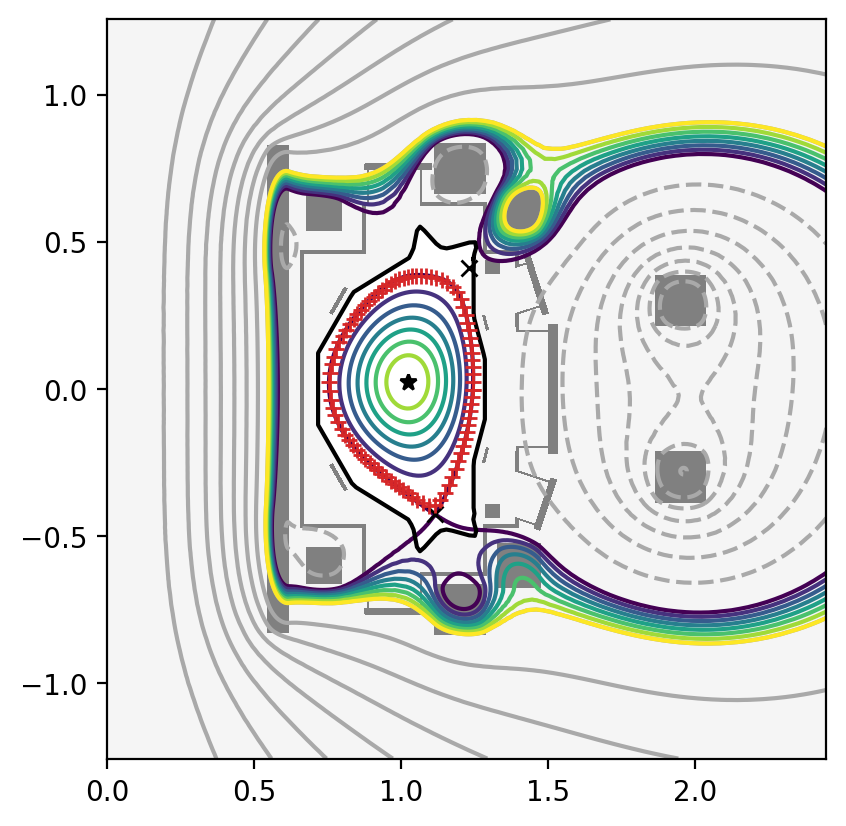

In [13]:
fig, ax = plt.subplots()
mygs.plot_psi(fig,ax)
mygs.plot_machine(fig,ax)
mygs.plot_constraints(fig,ax)

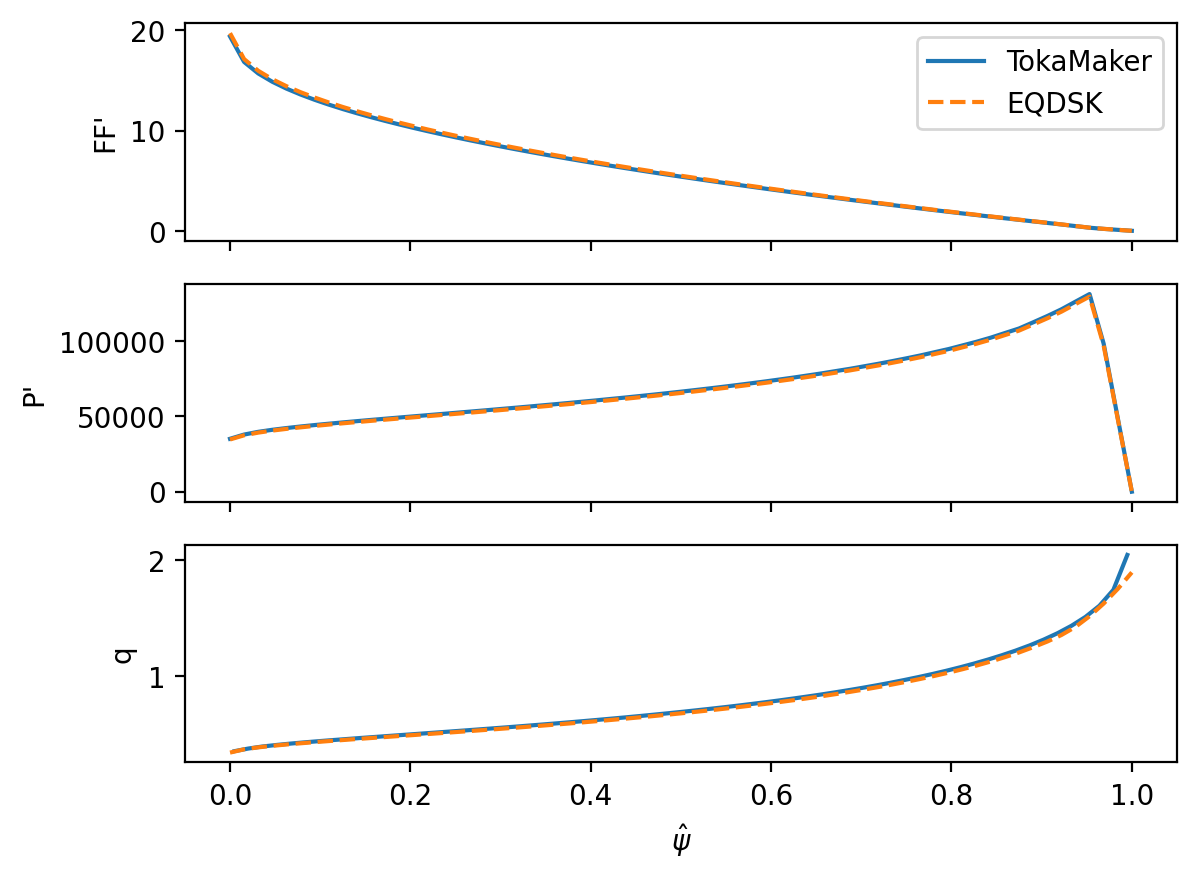

In [14]:
psi,f,fp,p,pp = mygs.get_profiles(npsi=np.size(ffprim))
psi_q,qvals,ravgs,dl,rbounds,zbounds = mygs.get_q(psi_pad=0.005,npsi=np.size(ffprim))
fig, ax = plt.subplots(3,1,sharex=True)
psi_eqdsk = np.linspace(0.0,1.0,eqdsk['nr'])
psi_sample = np.linspace(0.025,1.0,10)
# Plot F*F'
ax[0].plot(psi,f*fp,label='TokaMaker')
ax[0].plot(psi_eqdsk,eqdsk['ffprim'],'--',label='EQDSK')
ax[0].set_ylabel("FF'")
ax[0].legend()
# Plot P'
ax[1].plot(psi,pp)
ax[1].plot(psi_eqdsk,eqdsk['pprime'],'--')
ax[1].set_ylabel("P'")
# Plot q
ax[2].plot(psi_q,qvals)
ax[2].plot(psi_eqdsk,eqdsk['qpsi'],'--')
ax[2].set_ylabel("q")
_ = ax[-1].set_xlabel(r"$\hat{\psi}$")

In [15]:
tMaker_currs, _ = mygs.get_coil_currents()
# imap = [0,1,2,3,10,4,9,5,8,6,7,11,12]
for key, coil_set in mygs.coil_sets.items():
    i = coil_set['id']
    if i < len(imap) and imap[i] >= 0:
        print('{2} {0:.3E} {1:.3E}'.format(tMaker_currs[i],coil_currs[imap[i]]*1000.0,key))
    else:
        print('{1} {0:.3E}'.format(tMaker_currs[i],key))

CS_1 -6.831E+06 -6.831E+06
CS_2 -9.381E+06 -9.383E+06
CS_3 -6.123E+06 -6.121E+06
PF_1U -5.306E+05 -5.273E+05
PF_1L -1.350E+06 -1.346E+06
PF_2U -1.712E+06 -1.708E+06
PF_2L -7.852E+05 -7.816E+05
PF_3U 8.298E+05 8.307E+05
PF_3L 2.610E+05 2.622E+05
PF_4U -1.473E+06 -1.481E+06
PF_4L -1.236E+06 -1.244E+06
DIV_U -3.492E-07
DIV_L -4.521E-07


VDE L/R time = 1.7035E-02 [s]


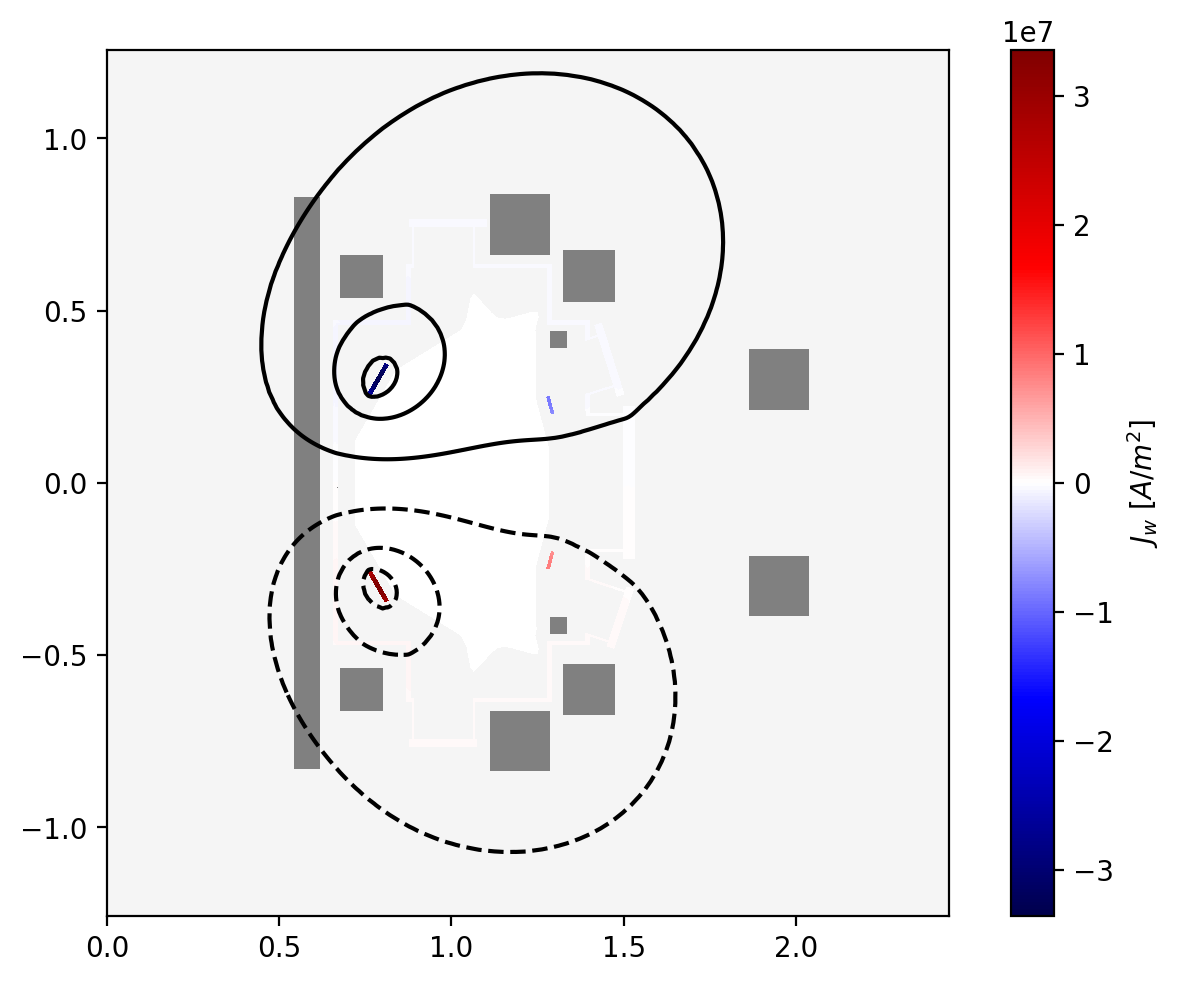

In [16]:
eig_vals, eig_vecs = mygs.eig_wall(10)
tau_wall = 1.0/eig_vals[1,0]
fig, ax = plt.subplots(1,1,constrained_layout=True)
mygs.plot_machine(fig,ax,limiter_color=None)
mygs.plot_psi(fig,ax,eig_vecs[1,:],xpoint_color=None,opoint_color=None,normalized=False,plasma_color='k')
mygs.plot_eddy(fig,ax,dpsi_dt=eig_vecs[1,:]*abs(eig_vals[1,0]),colormap='seismic',symmap=True)
print('VDE L/R time = {0:.4E} [s]'.format(tau_wall))

Growth rate = 1.7607E+02 [s^-1]
Growth time = 5.6797E-03 [s]
gamma*tau_w = 2.9993E+00


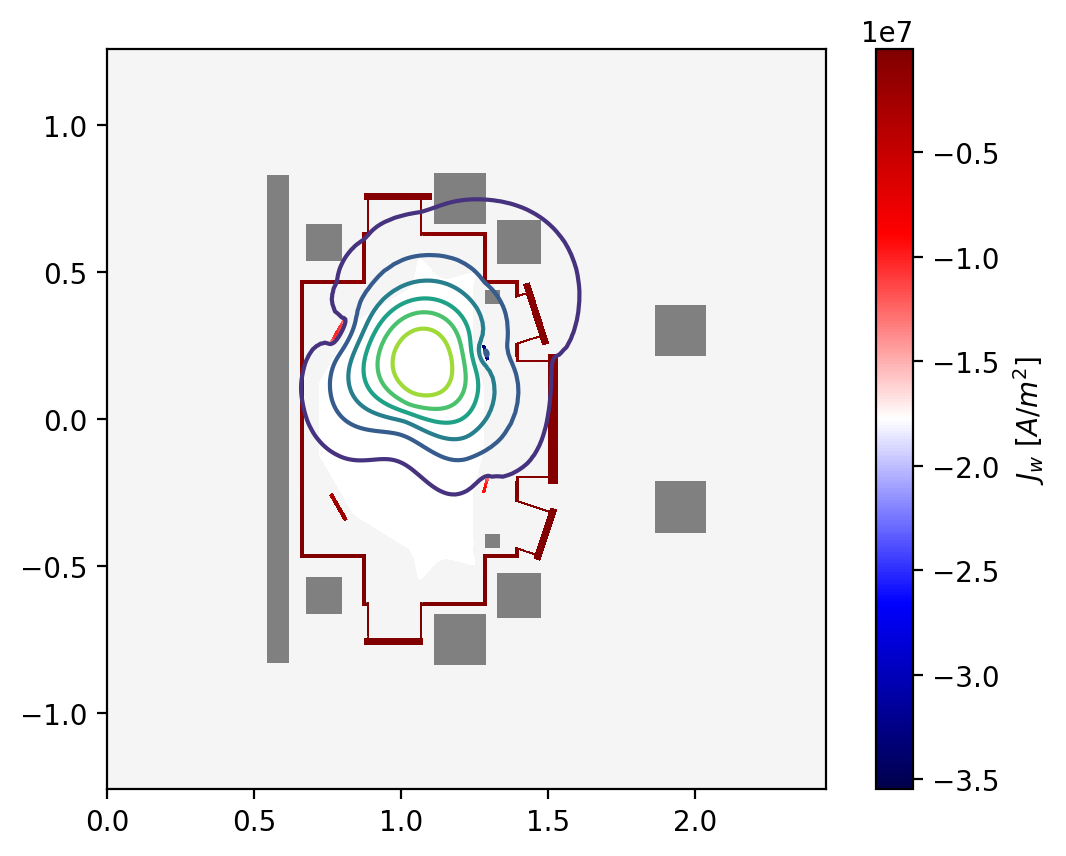

In [17]:
eig_vals, eig_vecs = mygs.eig_td(-5.E2,10,True)
fig, ax = plt.subplots()
mygs.plot_machine(fig,ax,limiter_color=None)
mygs.plot_psi(fig,ax,eig_vecs[0,:],normalized=False,xpoint_color=None,opoint_color=None)
mygs.plot_eddy(fig,ax,dpsi_dt=eig_vecs[0,:]*abs(eig_vals[0,0]),colormap='seismic')
if eig_vals[0,0] < 0.0:
    print('Growth rate = {0:.4E} [s^-1]'.format(-eig_vals[0,0]))
    print('Growth time = {0:.4E} [s]'.format(-1.0/eig_vals[0,0]))
    print('gamma*tau_w = {0:.4E}'.format(-eig_vals[0,0]*tau_wall))
else:
    print('Stable!')
    print('Decay time  = {0:.4E} [s]'.format(-1.0/eig_vals[0,0]))